In [62]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
import json
from pandas.io.json import json_normalize
from mlxtend.frequent_patterns import association_rules
from tqdm import tqdm
import networkx as nx
import flask
import seaborn as sns
%matplotlib inline

In [9]:
data = json.load(open('2017-12.json'))

In [10]:
rawDf = json_normalize(data['games'])
rawDf.head()

,added,card_history,coin,duration,hero,hero_deck,id,legend,mode,note,opponent,opponent_deck,rank,region,result,user_hash
0,2017-12-01T06:33:28Z,"[{'player': 'me', 'turn': 1, 'card': {'id': 'U...",False,521.0,Mage,Burn,97911097,None,casual,None,Paladin,Midrange,NaN,Americas,win,66FFB43E8DB8910A32FB03BD640103F6
1,2017-12-01T06:24:33Z,"[{'player': 'opponent', 'turn': 1, 'card': {'i...",False,666.0,Priest,None,97910783,None,casual,None,Shaman,None,NaN,Americas,loss,66FFB43E8DB8910A32FB03BD640103F6
2,2017-12-01T06:13:14Z,"[{'player': 'me', 'turn': 1, 'card': {'id': 'C...",False,585.0,Priest,None,97910404,None,casual,None,Mage,Secret,NaN,Americas,loss,66FFB43E8DB8910A32FB03BD640103F6
3,2017-12-01T02:23:44Z,"[{'player': 'opponent', 'turn': 1, 'card': {'i...",True,456.0,Priest,None,97901928,None,casual,None,Warrior,Taunt,NaN,Americas,loss,66FFB43E8DB8910A32FB03BD640103F6
4,2017-12-01T02:15:59Z,"[{'player': 'opponent', 'turn': 1, 'card': {'i...",False,729.0,Priest,None,97901622,None,casual,None,Druid,None,NaN,Americas,loss,66FFB43E8DB8910A32FB03BD640103F6


In [11]:
opponentCards = []
meCards = []
for game in rawDf['card_history']:
    meCardsPlayed = {}
    opponentCardsPlayed = {}
    dictSelect = {'me':meCardsPlayed, 'opponent':opponentCardsPlayed}
    for action in game:
        card = action['card']['name']
        dictionary = dictSelect[action['player']]
        dictionary[str(card)] = 1#dictionary.get(card, 0) + 1
    
    meCards.append(meCardsPlayed)
    opponentCards.append(opponentCardsPlayed)

In [12]:
meDf = pd.DataFrame(meCards)#.add_suffix('_me')
opponentDf = pd.DataFrame(opponentCards)#.add_suffix('_opponent')
df = meDf.append(opponentDf)
df = df.fillna(0).astype('int')
df.head()

,"""Little Friend""",A Light in the Darkness,Aberrant Berserker,Abominable Bowman,Abomination,Abusive Sergeant,Abyssal Enforcer,Acherus Veteran,Acidic Swamp Ooze,Acidmaw,...,Young Dragonhawk,Young Priestess,Youthful Brewmaster,Ysera,Ysera Awakens,Zarog's Crown,Zealous Initiate,Zola the Gorgon,Zombie Chow,Zoobot
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
def FilterCards(dfCards, cardDict):
    for col in dfCards.columns:
        if col not in cardDict:
            dfCards = dfCards.drop(col, axis=1)
            
    return dfCards

In [18]:
# Read in collectable card data
collectableCards = pd.read_json('collectableCards.json')
cardClass = dict(collectableCards[['name', 'cardClass']].values)

# Remove cards which are not collectable
df = FilterCards(df, cardClass)

In [20]:
def CrossProbabilities1(df):
    probDict = {}
    totalGames = df.shape[0]
    numCol = len(df.columns)
    
    for i in tqdm(range(numCol - 1)):
        col1 = df.columns[i]
        for j in range(numCol - i - 1):
            col2 = df.columns[i+j+1]
            probDict[(col1, col2)] = (df[col1] & df[col2]).sum() / totalGames
        
    df = pd.DataFrame.from_dict(probDict, orient='index')
    df = df.reset_index()
    df.columns = ['itemsets', 'support']
    return df
    
    
def CrossProbabilities2(df):
    frequentSets = apriori(df, min_support=0, use_colnames=True, max_len=2)

    indices = frequentSets['itemsets'].apply(len) > 1
    probabilities = frequentSets[indices]
    probabilities.sort_values('support')
    return probabilities.reset_index(drop=True)

In [21]:
probabilities = CrossProbabilities2(df)
probabilities = probabilities[probabilities['support'] != 0]

In [99]:
colorDict = {'warlock':'rgb(92,60,97)', 
             'mage':'rgb(86,100,139)',
             'hunter':'rgb(26,96,46)',
             'priest':'rgb(167,173,179)',
             'druid':'rgb(88,57,35)',
             'warrior':'rgb(134,45,36)',
             'rogue':'rgb(56,57,61)',
             'shaman':'rgb(57,68,111)',
             'paladin':'rgb(181,123,56)',
             'neutral':'rgb(130,107,97)'}

# colorDict = {'warlock':'purple', 
#              'mage':'lightblue',
#              'hunter':'green',
#              'priest':'white',
#              'druid':'lightbrown',
#              'warrior':'red',
#              'rogue':'darkgrey',
#              'shaman':'darkblue',
#              'paladin':'yellow',
#              'neutral':'darkbrown'}

In [100]:
# Filters out values with less than minSupport
# Then adds n top supported edges
# Card class is a dict which adds the name of the class 

def ProbabilitiesToGraph(df, cardClass=None, colorDict=None, minSupport=0, n=50):
    g = nx.Graph()
    
    # Filter out insufficient support
    df = df[df['support'] > minSupport]
    
    # Take top n
    df = df.sort_values('support', ascending=False).head(n)
    
    g.add_edges_from((df['itemsets']))
    
    for card in g:
        g.node[card]['radius'] = 3*np.sqrt(g.degree(card))
        if cardClass is not None:
            g.node[card]['class'] = cardClass[card]
            g.node[card]['color'] = colorDict[cardClass[card].lower()]
    
    return g    

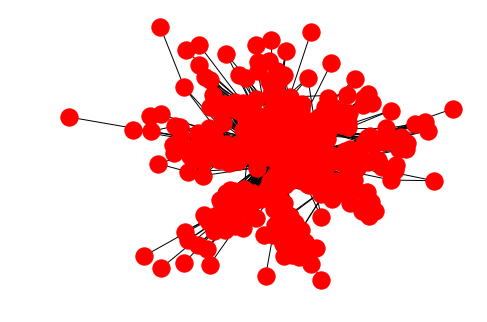

In [101]:
g = ProbabilitiesToGraph(probabilities, cardClass=cardClass, colorDict=colorDict, n=5000)
nx.draw(g)

In [102]:
d = nx.readwrite.json_graph.node_link_data(g)
json.dump(d, open('graphVisualization/graph.json','w'), indent=2)

In [103]:
# Serve the file over http to allow for cross origin requests
app = flask.Flask(__name__, static_folder="graphVisualization")

@app.route('/<path:path>')
def static_proxy(path):
    return app.send_static_file(path)

print('\nGo to http://localhost:8000/index.html to see the example\n')
app.run(port=8000)

 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)



Go to http://localhost:8000/index.html to see the example



127.0.0.1 - - [09/Feb/2018 01:47:02] "GET /index.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 01:47:03] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 01:53:03] "GET /index.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 01:53:03] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 01:59:45] "GET /index.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 01:59:45] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 02:00:31] "GET /index.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 02:00:31] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 02:21:07] "GET /index.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 02:21:07] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 02:21:40] "GET /index.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 02:21:40] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 02:24:32] "GET /index.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Feb/2018 02:24:32] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Fe